In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scipy.stats as st
from astropy.stats import LombScargle
import astropy.convolution as cv
from astropy.io import fits
sns.set_context('notebook')
plt.style.use('seaborn')
style = {
    'figure.figsize': (12, 8),
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 14,
}
rcParams.update(style)
import pymc3 as pm

In [3]:
lc = pd.read_table('data/kplr007107778_kasoc-ts_slc_v1.dat', sep='\s+', comment='#', names=['time', 'flux', 'flux_error'], dtype='f8')
psd = pd.read_table('data/kplr007107778_kasoc-psd_slc_v1.pow', sep='\s+', comment='#', names=['freq', 'power'], dtype='f8')

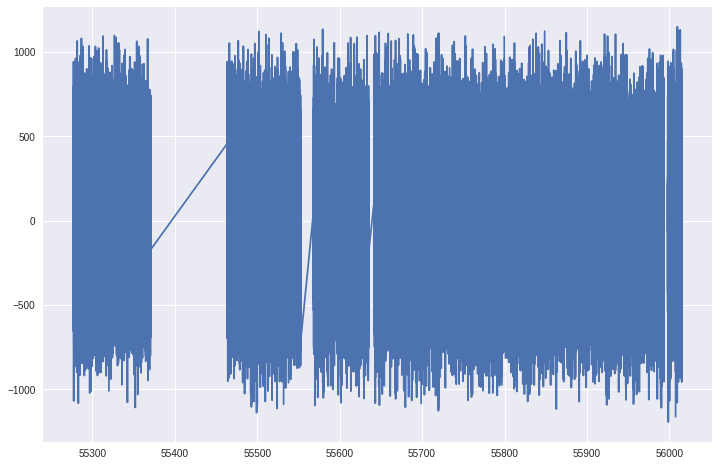

In [5]:
plt.plot(t, f);

In [59]:
freq, power = LombScargle(t, f, dy=ferr, fit_mean=False, center_data=False, normalization='psd').autopower()

In [4]:
mask = psd['freq'] > 12
full_freq = psd['freq'][mask].values
full_power = psd['power'][mask].values

In [14]:
# smoothed_power = cv.convolve(full_power, cv.Box1DKernel(6))
freq = np.arange(min(full_freq), max(full_freq), .5)
rpower = np.interp(freq, full_freq, full_power)
power = cv.convolve(rpower, cv.Box1DKernel(12))

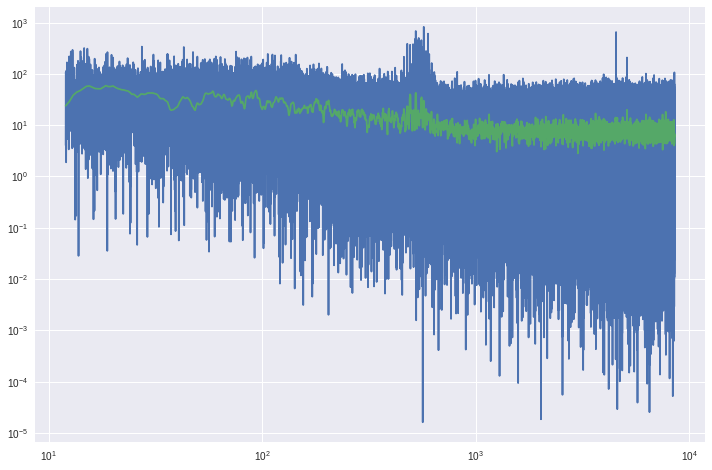

In [15]:
plt.loglog(full_freq, full_power)
plt.loglog(freq, power);

In [ ]:
v_nyq = 8496.36
with pm.Model() as model:
    W = pm.Bound(pm.Normal, lower=0)('W', mu=12, sd=1)
    R_v = (pm.math.sin( np.pi * freq / (2 * v_nyq)) / ((np.pi * freq) / (2 * v_nyq)))**2
    k=3
    a = pm.Normal('a', mu=np.array([59, 67, 76]).reshape(k,1), sd=8, shape=(k,1))
    
    b = pm.Normal('b', mu=np.array([5, 150, 400]).reshape(k,1), sd=np.array([1, 32, 64]).reshape(k,1), shape=(k,1))
    
    harv = pm.math.sum(2 * pm.math.sqrt(2) / np.pi * (a**2 / b) / (1 + (freq/b)**4), axis=0)
    
    H0 = pm.Bound(pm.Normal, lower=0)('H0', mu=18, sd=3)
    v_max = pm.Bound(pm.Normal, lower=0)('v_max', mu=568, sd=8)
    
    s = pm.InverseGamma('s', alpha=41, beta=2225)
    e = pm.HalfCauchy('e', 10)
    like = W + R_v * (harv + H0 * pm.math.exp(-(freq - v_max)**2) / (2 * s**2))
    
    y = pm.Normal('obs', mu=like, sd=e, observed=power)
    

In [ ]:
with model:
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e_log__, s_log__, v_max_lowerbound__, H0_lowerbound__, b, a, W_lowerbound__]
 46%|████▌     | 1377/3000 [01:37<01:54, 14.14it/s]

In [ ]:
pm.traceplot(trace);

In [ ]:
ppc = pm.sample_ppc(trace, 1000, model)
post = ppc['obs'].mean(axis=0)

In [ ]:
def harvey(v, a, b):
    return 2 * np.sqrt(2) / np.pi * (a**2 / b) / (1 + (v/b)**4)

In [ ]:
plt.loglog(full_freq, full_power, alpha=.6, c='.5')
plt.loglog(freq, power, 'C0')
plt.loglog(freq, post, 'C1')
plt.axvline(trace['v_max'].mean(), c='k', ls='--')
a = trace['a'].mean(axis=0)
b = trace['b'].mean(axis=0)
[plt.loglog(freq, harv, 'C2-.', alpha=.8) for harv in harvey(freq, a, b)]
plt.axhline(trace['W'].mean(), c='k', ls='--')
plt.ylim(1e-2, 1e4)
plt.xlim(1e1, 9e3);

In [ ]:
pm.summary(trace)